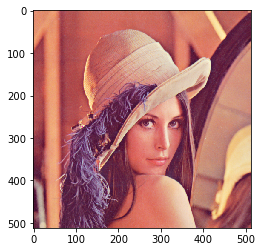

In [1]:
import numpy as np
from scipy.fftpack import dct 
from scipy.fftpack import idct 
from scipy.misc import imread
from skimage.util.shape import view_as_blocks
import matplotlib.pyplot as plot
 
def dct2(image):
    return dct(dct(image.T, norm='ortho').T, norm='ortho')

def idct2(coefficients):
    return idct(idct(coefficients.T, norm='ortho').T, norm='ortho')

def split_blocks(image, block_size):
    return view_as_blocks(green_channel, block_shape=(block_size, block_size))

def transform_blocks(blocks):
    return np.array([[transform(block) for block in line] for line in blocks])
    
def join_blocks(blocks):
    return blocks.swapaxes(1, 2).reshape(blocks.shape[0]*blocks.shape[2], -1)

def transform(block):
    return idct2(dct2(block)) + 10
    
    
image = imread('Lenna.png')
green_channel = np.array(image[:,:,1])
blocks = split_blocks(green_channel, 64)
blocks = transform_blocks(blocks) 
green_channel = join_blocks(blocks)
image[:,:,1] = green_channel
plot.imshow(image)
plot.show()